In [1]:
import sys
sys.path.append("..")
from res.plot_lib import plot_data, plot_model, set_default, plt

import numpy as np

In [2]:
def plot_np_data(X, y, d=0, auto=False, zoom=1):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap=plt.cm.Spectral)
    plt.axis('square')
    plt.axis(np.array((-1.1, 1.1, -1.1, 1.1)) * zoom)
    if auto is True: plt.axis('equal')
    plt.axis('off')

    _m, _c = 0, '.15'
    plt.axvline(0, ymin=_m, color=_c, lw=1, zorder=0)
    plt.axhline(0, xmin=_m, color=_c, lw=1, zorder=0)

In [3]:
import random
import jax
from jax import numpy as jnp
from flax import linen as nn
from flax.training import train_state
import math
import numpy as np
import optax

import torch
from torchvision import datasets, transforms

from IPython import display

In [4]:
def plot_jax_model(X, y, state):
    mesh = np.arange(-1.1, 1.1, 0.01)
    xx, yy = np.meshgrid(mesh, mesh)
    data = jnp.array(np.vstack((xx.reshape(-1), yy.reshape(-1))).T, dtype=float)
    Z = state.apply_fn({"params": state.params}, data)
    Z = np.argmax(Z, axis=1).reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.3)
    plot_np_data(X, y)

In [5]:
set_default()

In [6]:
seed = 12345
random.seed(seed)
np.random.seed(seed)
key = jax.random.PRNGKey(seed=seed)

In [7]:
input_size  = 28*28   # images are 28x28 pixels
output_size = 10      # there are 10 classes

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('mnist-data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=64, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('mnist-data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=1000, shuffle=True)

Files already downloaded


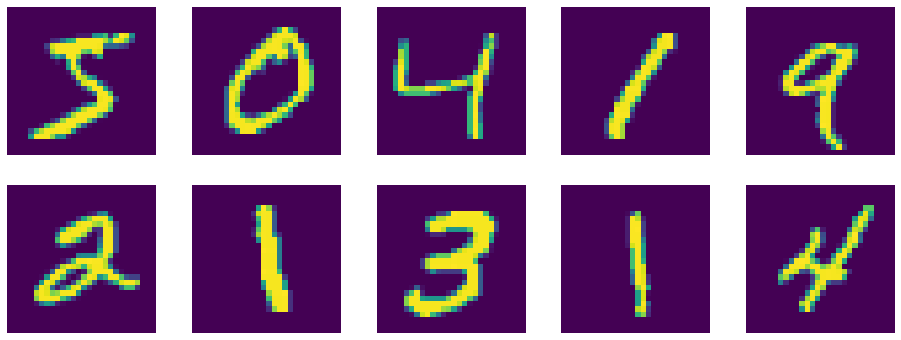

In [8]:
# show some images
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image, _ = train_loader.dataset.__getitem__(i)
    plt.imshow(image.squeeze().numpy())
    plt.axis('off');

In [35]:
class FC2Layer(nn.Module):
    """A fully connected 2 layer network"""
    input_size: int
    n_hidden: int 
    output_size: int 

    @nn.compact
    def __call__(self, x: jnp.ndarray):
        x = x.reshape((-1, self.input_size))
        x = nn.Dense(features=self.n_hidden)(x)
        x = nn.relu(x)
        x = nn.Dense(features=self.n_hidden)(x)
        x = nn.relu(x)
        x = nn.Dense(features=self.output_size)(x)

        return x


class CNN(nn.Module):
    """A convolutional neural net"""
    n_feature: int 
    output_size: int

    @nn.compact
    def __call__(self, x: jnp.ndarray):
        x = jnp.transpose(x, axes=(0, 2, 3, 1))
        x = nn.Conv(features=self.n_feature, kernel_size=(5, 5), padding="VALID")(x)
        x = nn.relu(x)
        x = nn.max_pool(x, window_shape=(2, 2))
        x = nn.Conv(features=self.n_feature, kernel_size=(5, 5), padding="VALID")(x)
        x = nn.relu(x)
        x = nn.max_pool(x, window_shape=(2, 2))
        x = x.reshape((x.shape[0], -1))
        x = nn.Dense(features=self.n_feature*4*4)(x)
        x = nn.relu(x)
        x = nn.Dense(features=self.output_size)(x)
        
        return x

In [36]:
@jax.jit
def train_step(state: train_state.TrainState, inputs: jnp.ndarray, labels: jnp.ndarray):
    def compute_loss(params):
        logits = state.apply_fn({"params": params}, inputs)
        labels_onehot = jax.nn.one_hot(labels, num_classes=10)
        cross_entropy_logloss = jnp.mean(optax.softmax_cross_entropy(logits=logits, labels=labels_onehot))
        
        return cross_entropy_logloss

    loss = compute_loss(params = state.params)
    grad_fn = jax.grad(compute_loss, has_aux=False)
    grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    accuracy = jnp.mean(jnp.argmax(state.apply_fn({"params": state.params}, inputs), -1) == labels)
    metrics = {
      'loss': loss,
      'accuracy': accuracy,
    }
    return state, metrics

@jax.jit
def evaluate(state: train_state.TrainState, inputs: jnp.ndarray):
    return state.apply_fn({"params": state.params}, inputs)

In [37]:
def create_training_state(model: nn.Module, rng: jax.random.PRNGKey, init_input_array: jnp.ndarray, 
                          learning_rate: float, momentum: float):
    params = model.init(rng, init_input_array).get("params")
    tx = optax.sgd(learning_rate=learning_rate, momentum=momentum)
    return train_state.TrainState.create(
        params=params,
        apply_fn=model.apply,
        tx=tx
    )

In [38]:
def train(epoch, state, perm=np.arange(0, 784)):
    epoch_loss, epoch_accuracy = [], []
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = jnp.array(data.numpy()), jnp.array(target.numpy())

        data = data.reshape((-1, 28*28))
        data = data[:, perm]
        data = data.reshape((-1, 1, 28, 28))

        state, metrics = train_step(state=state, inputs=data, labels=target)
        epoch_loss.append(metrics.get("loss"))
        epoch_accuracy.append(metrics.get("accuracy"))

        if batch_idx % 100 == 0:
            print(f"Train epoch: {epoch} [{batch_idx*len(data)}/{len(train_loader.dataset)}], loss = {metrics.get('loss')}")

    return state, np.mean(epoch_loss), np.mean(epoch_accuracy)

def test(state, perm=np.arange(0, 784)):
    correct = 0
    for data, target in test_loader:
        data, target = jnp.array(data.numpy()), jnp.array(target.numpy())

        data = data.reshape((-1, 28*28))
        data = data[:, perm]
        data = data.reshape((-1, 1, 28, 28))

        logits = evaluate(state=state, inputs=data)
        prediction = np.argmax(logits, axis=-1).reshape((-1, 1))
        correct += np.sum(np.equal(target.reshape((-1, 1)), prediction))

    accuracy = 100 * correct / len(test_loader.dataset)
    print(f"Test accuracy = {accuracy}")

## Train a small fully-connected network

In [13]:
n_hidden = 8

fcn_model = FC2Layer(input_size=28*28, n_hidden=n_hidden, output_size=10)
state = create_training_state(
    model=fcn_model,
    rng=key,
    init_input_array=jnp.ones(shape=(2, 1, 28, 28)),
    learning_rate=0.01,
    momentum=0.5
)

for epoch in range(0,1):
    state, loss, accuracy = train(epoch=epoch, state=state)
    print(f"Mean train accuracy = {accuracy}")
    test(state=state)

Train epoch: 0 [0/60000], loss = 2.4631207259371877
Train epoch: 0 [6400/60000], loss = 1.5814386935671791
Train epoch: 0 [12800/60000], loss = 1.1365695723798126
Train epoch: 0 [19200/60000], loss = 0.755014548649342
Train epoch: 0 [25600/60000], loss = 1.0089040628372459
Train epoch: 0 [32000/60000], loss = 0.4243820053206946
Train epoch: 0 [38400/60000], loss = 0.5418227097893293
Train epoch: 0 [44800/60000], loss = 0.6387840375682572
Train epoch: 0 [51200/60000], loss = 0.5867926106176355
Train epoch: 0 [57600/60000], loss = 0.3795636879350752
Mean train accuracy = 0.7246968150138855
Test accuracy = 88.3


## Train a Convnet with the same number of params

In [39]:
n_features = 6

model_cnn = CNN(
    n_feature=n_features,
    output_size=output_size
)

state = create_training_state(
    model=model_cnn,
    rng=key,
    init_input_array=jnp.ones(shape=(2, 1, 28, 28)),
    learning_rate=0.01,
    momentum=0.5
)

for epoch in range(0,1):
    state, loss, accuracy = train(epoch=epoch, state=state)
    print(f"Mean train accuracy = {accuracy}")
    test(state=state)

Train epoch: 0 [0/60000], loss = 2.410270346328616
Train epoch: 0 [6400/60000], loss = 0.24286423891237519
Train epoch: 0 [12800/60000], loss = 0.24869834802125013
Train epoch: 0 [19200/60000], loss = 0.07757386445627645
Train epoch: 0 [25600/60000], loss = 0.11621862320303755
Train epoch: 0 [32000/60000], loss = 0.06887502506250343
Train epoch: 0 [38400/60000], loss = 0.10124734343257202
Train epoch: 0 [44800/60000], loss = 0.10737445630341114
Train epoch: 0 [51200/60000], loss = 0.09020477139751826
Train epoch: 0 [57600/60000], loss = 0.12468210242930766
Mean train accuracy = 0.9724646806716919
Test accuracy = 97.86


# The ConvNet performs better with the same number of parameters, thanks to its use of prior knowledge about images

* Use of convolution: Locality and stationarity in images
* Pooling: builds in some translation invariance

# What happens if the assumptions are no longer true?


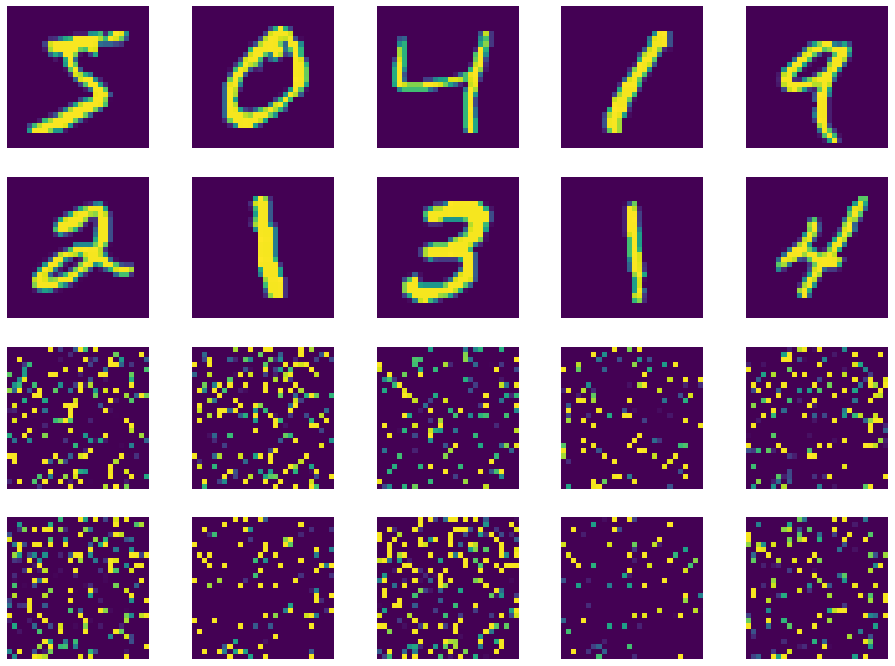

In [40]:
perm = torch.randperm(784)
plt.figure(figsize=(16, 12))
for i in range(10):
    image, _ = train_loader.dataset.__getitem__(i)
    # permute pixels
    image_perm = image.view(-1, 28*28).clone()
    image_perm = image_perm[:, perm]
    image_perm = image_perm.view(-1, 1, 28, 28)
    plt.subplot(4, 5, i + 1)
    plt.imshow(image.squeeze().numpy())
    plt.axis('off')
    plt.subplot(4, 5, i + 11)
    plt.imshow(image_perm.squeeze().numpy())
    plt.axis('off')

# ConvNet with permuted pixels

In [43]:
n_features = 6

model_cnn = CNN(
    n_feature=n_features,
    output_size=output_size
)

state = create_training_state(
    model=model_cnn,
    rng=key,
    init_input_array=jnp.ones(shape=(2, 1, 28, 28)),
    learning_rate=0.01,
    momentum=0.5
)

for epoch in range(0,1):
    state, loss, accuracy = train(epoch=epoch, state=state, perm=perm.numpy())
    print(f"Mean train accuracy = {accuracy}")
    test(state=state, perm=perm.numpy())

Train epoch: 0 [0/60000], loss = 2.3925074096769094
Train epoch: 0 [6400/60000], loss = 0.5090667887707241
Train epoch: 0 [12800/60000], loss = 0.4500707820925527
Train epoch: 0 [19200/60000], loss = 0.2746566579817227
Train epoch: 0 [25600/60000], loss = 0.3887696179388058
Train epoch: 0 [32000/60000], loss = 0.27138588775483186
Train epoch: 0 [38400/60000], loss = 0.37039270255576184
Train epoch: 0 [44800/60000], loss = 0.21511688029357856
Train epoch: 0 [51200/60000], loss = 0.222780406004631
Train epoch: 0 [57600/60000], loss = 0.11881311429647212
Mean train accuracy = 0.8989372253417969
Test accuracy = 92.58


# Fully-Connected with Permuted Pixels

In [46]:
n_hidden = 8

fcn_model = FC2Layer(input_size=28*28, n_hidden=n_hidden, output_size=10)
state = create_training_state(
    model=fcn_model,
    rng=key,
    init_input_array=jnp.ones(shape=(2, 1, 28, 28)),
    learning_rate=0.01,
    momentum=0.5
)

for epoch in range(0,1):
    state, loss, accuracy = train(epoch=epoch, state=state, perm=perm.numpy())
    print(f"Mean train accuracy = {accuracy}")
    test(state=state, perm=perm.numpy())

Train epoch: 0 [0/60000], loss = 2.327005112543702
Train epoch: 0 [6400/60000], loss = 1.6008871184894815
Train epoch: 0 [12800/60000], loss = 1.2409695260575972
Train epoch: 0 [19200/60000], loss = 0.9050692732562311
Train epoch: 0 [25600/60000], loss = 0.5749205302890914
Train epoch: 0 [32000/60000], loss = 0.4646576050326985
Train epoch: 0 [38400/60000], loss = 0.2772768550203182
Train epoch: 0 [44800/60000], loss = 0.4882042231606647
Train epoch: 0 [51200/60000], loss = 0.3956892474958238
Train epoch: 0 [57600/60000], loss = 0.18575538707864325
Mean train accuracy = 0.758029043674469
Test accuracy = 88.27
